In [1]:
import os, sys
import pytorch_lightning as pl
import torch
from rdkit import Chem
import numpy as np
import rdkit.Chem.Descriptors
from IPython.display import Image, display
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
sys.path.append("../../..")

In [2]:
#relaod during dev
import importlib
for k,v in sys.modules.items():
    if k.startswith('molNet'):
        importlib.reload(v)

First we start with a simple example by predicting the molar masses of random molecules (**maybe library for creating pseudo random molecules**). As a featurization the mass of each individual atom was used. As a result the model should be trained to simply add all individual atomic masses. 

Thus first we create the model without any graph convolutional layer and as a pooling function sum pooling is used:

In [3]:
#first a blank mol dataset
from molNet.dataloader.datasets import DelaneySolubility
dataset=DelaneySolubility().df
dataset["rd_mol"] = dataset['SMILES'].apply(lambda s: Chem.MolFromSmiles(s))
dataset["molar_mass"] = dataset['rd_mol'].apply(lambda mol: Chem.Descriptors.MolWt(mol))
dataset

,name,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,rd_mol,molar_mass
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",167.850
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",133.405
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",167.850
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",133.405
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",187.375
...,...,...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC),"<img data-content=""rdkit/molecule"" src=""data:i...",287.343
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,"<img data-content=""rdkit/molecule"" src=""data:i...",286.114
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,"<img data-content=""rdkit/molecule"" src=""data:i...",308.333
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,"<img data-content=""rdkit/molecule"" src=""data:i...",354.815


In [4]:
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_mass

loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         seed=1,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True})
loader.setup()

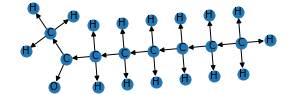

In [5]:
for i in loader.train_dataloader():
    display(i.mol_graph[0])
    break

In [6]:
def plot_true_pred(model,loader):
    

    true=[]
    pred=[]
    for i,d in enumerate(loader.test_dataloader()):
        true.extend(d.y.detach().numpy()[:,0])
        pred.extend(model(d).detach().numpy()[:,0])
 
    plt.plot(true,pred,"o")
    plt.show()
    plt.close()

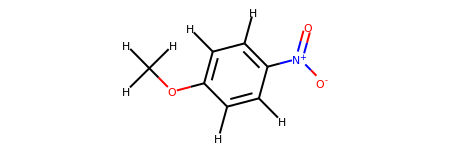

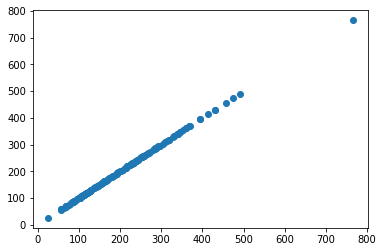

In [7]:
# noinspection JupyterPackage
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader, PytorchGeomMolGraphGenerator, \
    SmilesfromDfLoader
from molNet.dataloader.datasets import DelaneySolubility
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats*100

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)
        

# no parameter and thus no training necessary
model = SimpleSumAtomMassesModel()
#dataloader=DelaneySolubility().to_pytorchgeo_molgraph_generator(
#    to_graph_params = dict(with_properties=True,atom_featurizer=atom_mass,with_mol_graph=True),
#    generator_params={"shuffle":False}
#)

#loader = PytorchGeomMolGraphFromGeneratorLoader(
#    *dataloader,
#    batch_size=1)


loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         seed=2,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True},
                                        batch_size=1
                                        )

loader.setup()


test_smiles="COc1ccc([N+](=O)[O-])cc1"
test_data=None
for i,d in enumerate(loader.test_dataloader()):
    if d.string_data[0][0][1] == test_smiles:
        test_data=d
    #display(d.mol_graph[0].mol)
    #display(d.mol_graph[0])
 #   print(i)
#    print(d.string_data[0][0])
#    print(d.string_data_titles)
#    break
display(test_data.mol_graph[0].mol)
Image(test_data.mol_graph[0].get_png())
plot_true_pred(model,loader)

This is actually no machine learning model, since there are no trainable parameters. Basicall only a sum over all features - atom masses in this case - is perfomed. Obviously the result matches the real mass of the underlying molecule

If the featurizer is replaced with an atom type featurizer. The feature vector of each atom is not an single scalar value representing the atomic mass, but an one hot encoding vector for the atom type:

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | gcn     | GCNConv | 96    
1 | pooling | PoolSum | 0     


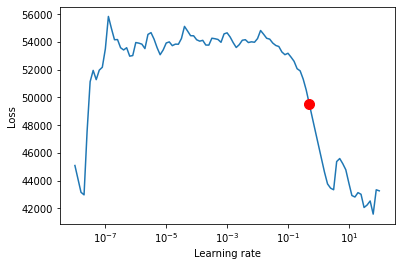

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | gcn     | GCNConv | 96    
1 | pooling | PoolSum | 0     


set lr to 0.5011872336272725


{'train_loss': tensor(2564.1216, device='cuda:0'), 'val_loss': tensor(3519.1084, device='cuda:0')}


{'train_loss': tensor(1686.5847, device='cuda:0'), 'val_loss': tensor(2449.1663, device='cuda:0')}


{'train_loss': tensor(745.4277, device='cuda:0'), 'val_loss': tensor(1501.5798, device='cuda:0')}


{'train_loss': tensor(391.9262, device='cuda:0'), 'val_loss': tensor(1003.3436, device='cuda:0')}


{'train_loss': tensor(224.3606, device='cuda:0'), 'val_loss': tensor(710.8926, device='cuda:0')}


{'train_loss': tensor(138.0999, device='cuda:0'), 'val_loss': tensor(529.1567, device='cuda:0')}


{'train_loss': tensor(90.8828, device='cuda:0'), 'val_loss': tensor(408.7792, device='cuda:0')}


{'train_loss': tensor(62.9174, device='cuda:0'), 'val_loss': tensor(323.4079, device='cuda:0')}


{'train_loss': tensor(44.7293, device='cuda:0'), 'val_loss': tensor(259.3733, device='cuda:0')}


{'train_loss': tensor(32.2674, device='cuda:0'), 'val_loss': tensor(209.7128, device='cuda:0')}


{'train_loss': tensor(23.5354, device='cuda:0'), 'val_loss': tensor(170.5658, device='cuda:0')}


{'train_loss': tensor(17.3165, device='cuda:0'), 'val_loss': tensor(139.4733, device='cuda:0')}


{'train_loss': tensor(12.8693, device='cuda:0'), 'val_loss': tensor(114.6709, device='cuda:0')}


{'train_loss': tensor(9.6993, device='cuda:0'), 'val_loss': tensor(94.8127, device='cuda:0')}


{'train_loss': tensor(7.4488, device='cuda:0'), 'val_loss': tensor(78.8441, device='cuda:0')}


{'train_loss': tensor(5.8589, device='cuda:0'), 'val_loss': tensor(65.9339, device='cuda:0')}


{'train_loss': tensor(4.7406, device='cuda:0'), 'val_loss': tensor(55.4274, device='cuda:0')}


{'train_loss': tensor(3.9559, device='cuda:0'), 'val_loss': tensor(46.8125, device='cuda:0')}


{'train_loss': tensor(3.4061, device='cuda:0'), 'val_loss': tensor(39.6919, device='cuda:0')}


{'train_loss': tensor(3.0201, device='cuda:0'), 'val_loss': tensor(33.7586, device='cuda:0')}


{'train_loss': tensor(2.7477, device='cuda:0'), 'val_loss': tensor(28.7773, device='cuda:0')}


{'train_loss': tensor(2.5539, device='cuda:0'), 'val_loss': tensor(24.5677, device='cuda:0')}


{'train_loss': tensor(2.4142, device='cuda:0'), 'val_loss': tensor(20.9911, device='cuda:0')}


{'train_loss': tensor(2.3116, device='cuda:0'), 'val_loss': tensor(17.9412, device='cuda:0')}


{'train_loss': tensor(2.2345, device='cuda:0'), 'val_loss': tensor(15.3343, device='cuda:0')}


{'train_loss': tensor(2.1746, device='cuda:0'), 'val_loss': tensor(13.1047, device='cuda:0')}


{'train_loss': tensor(2.1265, device='cuda:0'), 'val_loss': tensor(11.1994, device='cuda:0')}


{'train_loss': tensor(2.0866, device='cuda:0'), 'val_loss': tensor(9.5750, device='cuda:0')}


{'train_loss': tensor(2.0520, device='cuda:0'), 'val_loss': tensor(8.1953, device='cuda:0')}


{'train_loss': tensor(2.0212, device='cuda:0'), 'val_loss': tensor(7.0297, device='cuda:0')}


{'train_loss': tensor(1.9933, device='cuda:0'), 'val_loss': tensor(6.0517, device='cuda:0')}


{'train_loss': tensor(1.9684, device='cuda:0'), 'val_loss': tensor(5.2385, device='cuda:0')}


{'train_loss': tensor(1.9468, device='cuda:0'), 'val_loss': tensor(4.5698, device='cuda:0')}


{'train_loss': tensor(1.9300, device='cuda:0'), 'val_loss': tensor(4.0277, device='cuda:0')}


{'train_loss': tensor(1.9199, device='cuda:0'), 'val_loss': tensor(3.5959, device='cuda:0')}


{'train_loss': tensor(1.9187, device='cuda:0'), 'val_loss': tensor(3.2588, device='cuda:0')}


{'train_loss': tensor(1.9282, device='cuda:0'), 'val_loss': tensor(3.0016, device='cuda:0')}


{'train_loss': tensor(1.9492, device='cuda:0'), 'val_loss': tensor(2.8100, device='cuda:0')}


{'train_loss': tensor(1.9802, device='cuda:0'), 'val_loss': tensor(2.6703, device='cuda:0')}


{'train_loss': tensor(2.0179, device='cuda:0'), 'val_loss': tensor(2.5696, device='cuda:0')}


{'train_loss': tensor(2.0576, device='cuda:0'), 'val_loss': tensor(2.4979, device='cuda:0')}


{'train_loss': tensor(2.0940, device='cuda:0'), 'val_loss': tensor(2.4473, device='cuda:0')}


{'train_loss': tensor(2.1235, device='cuda:0'), 'val_loss': tensor(2.4131, device='cuda:0')}


{'train_loss': tensor(2.1440, device='cuda:0'), 'val_loss': tensor(2.3925, device='cuda:0')}


{'train_loss': tensor(2.1563, device='cuda:0'), 'val_loss': tensor(2.3837, device='cuda:0')}


{'train_loss': tensor(2.1617, device='cuda:0'), 'val_loss': tensor(2.3853, device='cuda:0')}


{'train_loss': tensor(2.1623, device='cuda:0'), 'val_loss': tensor(2.3958, device='cuda:0')}


{'train_loss': tensor(2.1595, device='cuda:0'), 'val_loss': tensor(2.4134, device='cuda:0')}



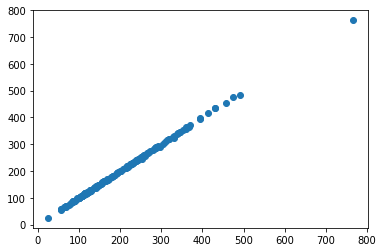

In [15]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from torch_geometric.nn import GCNConv
from molNet.nn.models.graph_convolution import PoolWeightedSum, PoolSum
import torch.nn.functional as F

class MolWeigtFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.gcn = GCNConv(in_channels=in_size,out_channels=1)
        self.pooling =PoolSum()
        self.lr = 1e-1

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.gcn(feats, edges)
        feats = self.pooling(feats, batch)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log('val_loss', loss)
        return loss
    
try:
    model = MolWeigtFromTypeModel.load_from_checkpoint(os.path.join("models","MolWeigtFromTypeModel","model.ckpt"),map_location=lambda storage, location: storage)
except FileNotFoundError:
    
    loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         seed=2,
                                         to_graph_params={"atom_featurizer":atom_symbol_one_hot,"with_mol_graph":True},
                                        batch_size=32#,num_workers=16
                                        )
    loader.setup()
    model = MolWeigtFromTypeModel(in_size=len(atom_symbol_one_hot))
    trainer = pl.Trainer()
    lr_finder = trainer.tuner.lr_find(model,train_dataloader=loader.train_dataloader(),max_lr=10**2)
    fig = lr_finder.plot(suggest=True)
    plt.show()
    plt.close()
    # Pick point based on plot, or get suggestion
    model.lr = lr_finder.suggestion()
    print("set lr to",model.lr)
    
    
    class DCB(pl.callbacks.Callback):
        def on_epoch_end(self,trainer, pl_module):
            logs = trainer.callback_metrics
            print(logs)
    
    trainer = pl.Trainer(max_epochs=1000,gpus=torch.cuda.device_count(),
                        callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss'),DCB()]
                        )
    trainer.fit(model,loader)


plot_true_pred(model,loader)

30 0.05499036 26.038 24.606161


22 0.024110215 56.064 54.712284


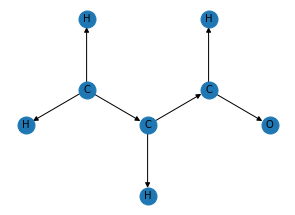

19 0.035791945 90.191 86.96289


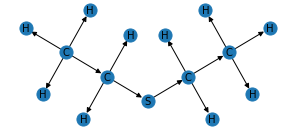

24 0.027419705 252.731 245.8012


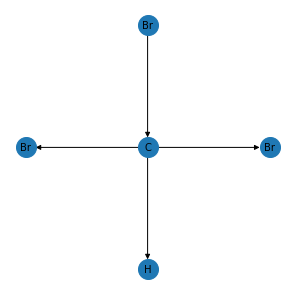

14 0.026644398 173.835 169.20328


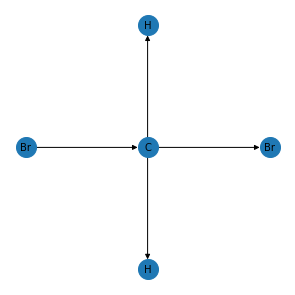

6 0.016227767 490.639 482.67703


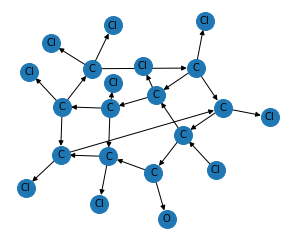

In [12]:

for i,d in enumerate(loader.test_dataloader()):
    t = (d.y.detach().numpy()[:,0])
    p = (model(d).detach().numpy()[:,0])
    er=np.abs((p-t)/t)
    maxi = np.argmax(er)
    print(maxi,er[maxi],t[maxi],p[maxi])
    display(d.mol_graph[maxi])

None


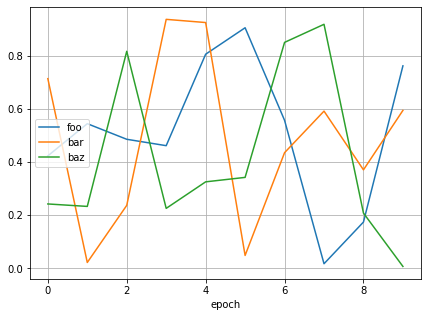

In [17]:
import collections
from IPython.display import clear_output
def live_plot(data_dict, figsize=(7,5), title=''):
    print(clear_output(wait=True))
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()
    
data = collections.defaultdict(list)
for i in range(10):
    data['foo'].append(np.random.random())
    data['bar'].append(np.random.random())
    data['baz'].append(np.random.random())
    live_plot(data)

In [38]:
model.lr

0.1